## A Kaggle Submission for Bike Sharing Demand Competition
Summit Bhalla  
References from Peter Prettenhofer's work on scikit-learn GBRT implementation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import os.path

from sklearn import ensemble
from sklearn.grid_search import GridSearchCV
%matplotlib inline

file_path = os.path.dirname(os.path.realpath('__file__'))
raw_train = os.path.join(file_path,'data/train.csv')
raw_test = os.path.join(file_path, 'data/test.csv')

# Load train and test data and explore
traincv = pd.read_csv(raw_train, parse_dates=['datetime'])
test = pd.read_csv(raw_test, parse_dates=['datetime'])

10886
hour
0     3.737263
1     3.104906
2     2.616180
3     2.134851
4     1.837286
5     2.779294
6     3.938768
7     4.917899
8     5.575184
9     5.284876
10    4.998863
11    5.162997
12    5.374850
13    5.377655
14    5.304810
15    5.359728
16    5.617140
17    6.000667
18    5.898224
19    5.591497
20    5.269461
21    4.996949
22    4.736082
23    4.315009
Name: log_count, dtype: float64


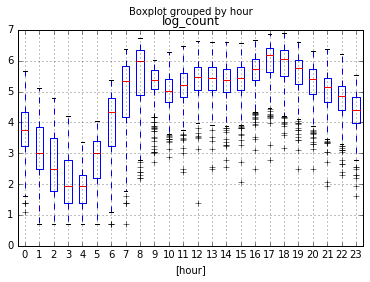

In [211]:
hour = pd.DatetimeIndex(traincv['datetime']).hour
print len(hour)
print traincv.groupby('hour')['log_count'].mean()
ax = traincv.boxplot(column=['log_count'], by=['hour'], return_type='axes')


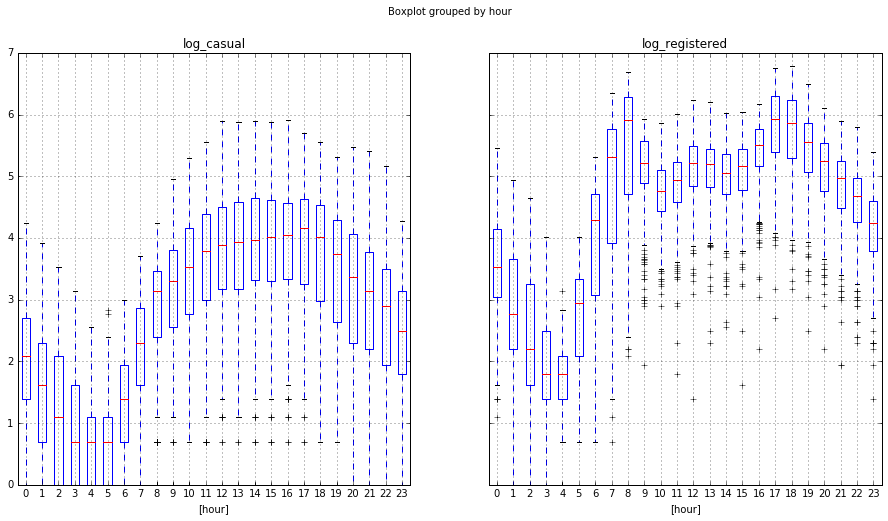

In [220]:
fig = plt.figure(figsize=(15,10))
ax = traincv.boxplot(column=['log_casual','log_registered'], by=['hour'], return_type='axes', figsize=(15,8),layout=(1,2))
#ax.set_ylabel('blah')


In [196]:
print np.random.rand(10,2)


[[ 0.62119144  0.55104952]
 [ 0.32505094  0.02552723]
 [ 0.41920923  0.68309818]
 [ 0.15864159  0.71850688]
 [ 0.57019583  0.08963065]
 [ 0.04429195  0.96403352]
 [ 0.06471129  0.4607433 ]
 [ 0.693274    0.99144282]
 [ 0.49737548  0.59785594]
 [ 0.20010524  0.982729  ]]


In [3]:
# Extract the month / day / hour fields as features
temp = pd.DatetimeIndex(traincv['datetime'])
traincv['year'] = temp.year
traincv['month'] = temp.month
traincv['hour'] = temp.hour
traincv['weekday'] = temp.weekday

temp = pd.DatetimeIndex(test['datetime'])
test['year'] = temp.year
test['month'] = temp.month
test['hour'] = temp.hour
test['weekday'] = temp.weekday

# Define features vector
features = ['season', 'holiday', 'workingday', 'weather',
            'temp', 'atemp', 'humidity', 'windspeed', 'year',
            'month', 'weekday', 'hour']

[[<matplotlib.axes._subplots.AxesSubplot object at 0x117c4e550>


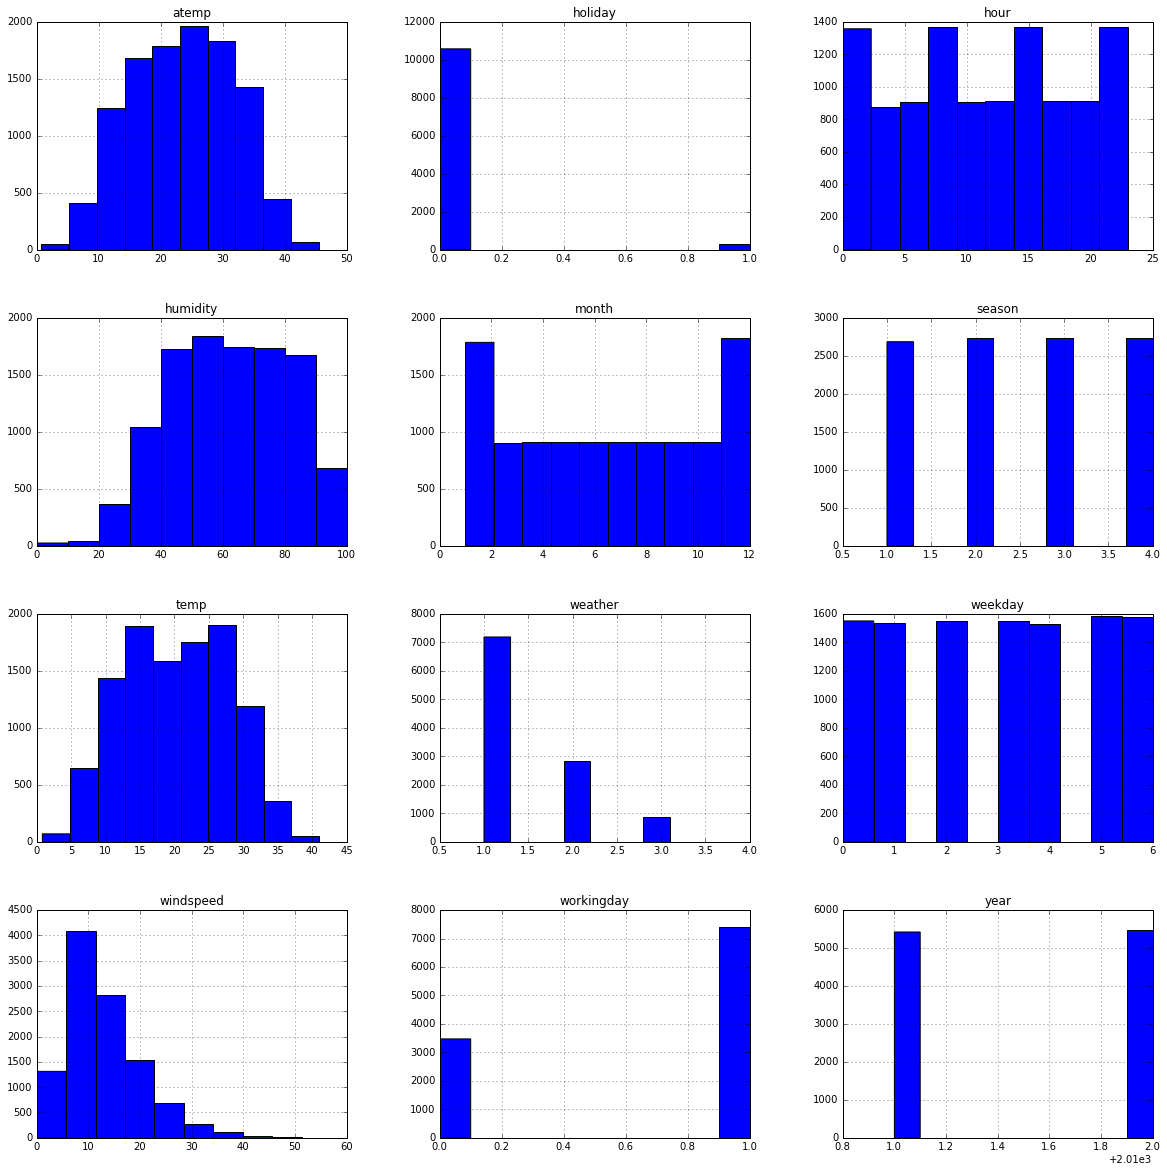

In [4]:
print traincv.hist(column=['season', 'holiday', 'workingday', 'weather',
            'temp', 'atemp', 'humidity', 'windspeed', 'year',
            'month', 'weekday', 'hour'],figsize=(20,20))


In [42]:
# transform response label in log scale to match the loss function used in
# the competition
traincv[['log_casual', 'log_registered', 'log_count']] = traincv[
    ['casual', 'registered', 'count']].applymap(lambda x: np.log1p(x))

#training and validation split
temp = pd.DatetimeIndex(traincv['datetime'])
train = traincv[temp.day <= 16]
val = traincv[temp.day > 16]

In [153]:
#function to plot deviance -- enhanced from Peter Prettenhofer talk
def deviance_plot(est, X_test, y_test, est2=None, y_test2=None, ax=None, label='', 
                  train_color='#2c7bb6', test_color='#d7191c', alpha=1.0, ylim=(0,0.5)):
    """Deviance plot for ``est``, use ``X_test`` and ``y_test`` for test error. """
    test_dev = np.empty(n_estimators)
    train_dev = est.train_score_

    for i, pred in enumerate(est.staged_predict(X_test)):
        test_dev[i] = est.loss_(y_test, pred)

    if est2 or y_test2 is not None:        
        for i, pred in enumerate(est2.staged_predict(X_test)):
            test_dev[i] = (test_dev[i] + est2.loss_(y_test2, pred)) / 2
        train_dev = (train_dev + est2.train_score_) / 2
    
    if ax is None:
        fig = plt.figure(figsize=(10, 5))
        ax = plt.gca()

    ax.plot(np.arange(n_estimators) + 1, test_dev, color=test_color, label='Validation %s' % label,
             linewidth=2, alpha=alpha)
    ax.plot(np.arange(n_estimators) + 1, train_dev, color=train_color,
             label='Train %s' % label, linewidth=2, alpha=alpha)
    ax.set_ylabel('Error')
    ax.set_xlabel('n_estimators')
    ax.set_ylim(ylim)
    ax.legend(loc='upper right')

    return test_dev, ax

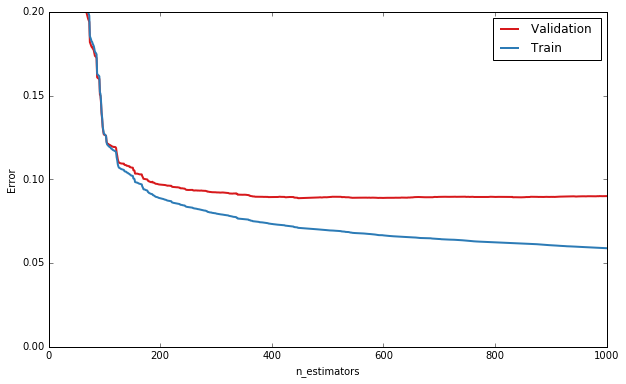

In [125]:
#use gradient boosting regressor estimator from scikit learn package

n_estimators = 1000
est = ensemble.GradientBoostingRegressor(n_estimators=n_estimators)

est.fit(train[features],train['log_count'])

test_dev, ax = deviance_plot(est,val[features],val['log_count'])
ax.legend(loc='upper right')


In [128]:
def gs_hparams(est, X_train, Y_train):
    param_grid = {'learning_rate': [0.1, 0.05, 0.02, 0.01],
                  'max_depth': [4, 6],
                  'min_samples_leaf': [3, 5, 9, 17],
                  'max_features': [1.0, 0.3, 0.1] 
                  }
    return GridSearchCV(est,param_grid,n_jobs=4).fit(X_train, Y_train)

est_casual = ensemble.GradientBoostingRegressor(n_estimators=5000)
est_reg = ensemble.GradientBoostingRegressor(n_estimators=5000)

gs_casual = gs_hparams(est_casual,train[features],train['log_casual'])
gs_reg = gs_hparams(est_reg,train[features],train['log_registered'])



{'max_features': 0.3, 'learning_rate': 0.01, 'max_depth': 4, 'min_samples_leaf': 17}


In [130]:
#keeping training n_estimators for now.... 3000. Might be overfitting. 
# casual = {'max_features': 0.3, 'learning_rate': 0.01, 'max_depth': 4, 'min_samples_leaf': 17}
# registered = {'max_features': 0.3, 'learning_rate': 0.02, 'max_depth': 4, 'min_samples_leaf': 17}
est_casual.set_params(**gs_casual.best_params_)
est_reg.set_params(**gs_reg.best_params_)

est_casual.fit(train[features],train['log_casual'])
est_reg.fit(train[features],train['log_registered'])

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.02, loss='ls',
             max_depth=4, max_features=0.3, max_leaf_nodes=None,
             min_samples_leaf=17, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=5000,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

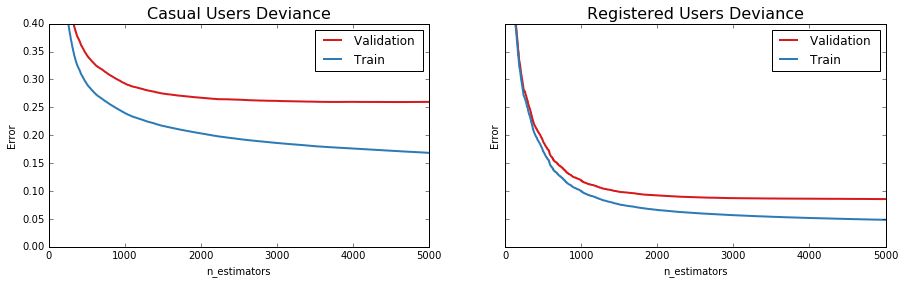

In [157]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figwidth(15)
_ = deviance_plot(est_casual,val[features],val['log_casual'], ax=ax1, ylim=(0,0.4))
_ = deviance_plot(est_reg,val[features],val['log_registered'], ax=ax2, ylim=(0,0.4))
ax1.set_title("Casual Users Deviance", fontsize=16)
ax2.set_title("Registered Users Deviance", fontsize=16)


Notes:
 - Casual users are contributing towards the majority of overall prediction loss. Will have to investigate further, first let's submit this model and continually make improvements.
 - Deviance plot shows roughly 3500 trees is optimal for choice between validation loss and model complexity. 
 - For model evaluation, we held out a validation set (although some hyperparmaters were grid searched using 3-fold CV). For the kaggle submission, we'll train the model on the full training dataset. 

In [159]:
opt_trees = 3500
est_casual_submit = ensemble.GradientBoostingRegressor(n_estimators=opt_trees)
est_reg_submit = ensemble.GradientBoostingRegressor(n_estimators=opt_trees)

est_casual_submit.set_params(**gs_casual.best_params_)
est_reg_submit.set_params(**gs_reg.best_params_)

est_casual.fit(traincv[features],traincv['log_casual'])
est_reg.fit(traincv[features],traincv['log_registered'])


GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.02, loss='ls',
             max_depth=4, max_features=0.3, max_leaf_nodes=None,
             min_samples_leaf=17, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=3500,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

Next Steps:
- Merge demand predictions for registered and casual users into an overall demand prediction
- Export predictions to csv file
- Check ranking on Kaggle public leaderboard!

In [ ]:
def merge_predictions(m1, m2, test_set):
    #make predictions and convert from log transform
    pred1 = np.expm1(m1.predict(test_set))
    pred2 = np.expm1(m2.predict(test_set))
    return pred1+pred2

def csv_export(preds, fname):
    # export to csv for Kaggle entry
    export_df=pd.DataFrame({'datetime':test['datetime'], 'count':preds})
    export_df.to_csv(fname, index = False, columns=['datetime','count'])

predictions = merge_predictions(est_casual_submit, est_reg_submit, test[features])

fname = os.path.join(file_path,'submissions/preds1.csv')
csv_export(predictions,fname)